## GOAL

Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.

## HIGH LEVEL STEPS

1. Load the dataset and necessary libraries.
2. Explore the dataset and handle missing values, specifically handle 'Select' values before the missing value treatment.
3. Replace numeric NaN with median and categorical NaN with mode.
4. Preprocess the data: encode categorical variables, using one Hot encoding.
5. Split the data into training and test sets.
6. Build and train the logistic regression model.
7. Evaluate the model using various metrics.

In [1]:
#for data analysis
import numpy as np
import pandas as pd

#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for train-test and Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#for modelling
import statsmodels.api as sm

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Use cross-validation and grid search to optimize hyperparameters
from sklearn.model_selection import GridSearchCV

#extra
import warnings
warnings.filterwarnings('ignore')

### RE-USABLE FUNCTIONS 

In [2]:
def replace_nan_with_mode(df, column_list):
    """
    Replaces NaN values with the mode in the specified categorical columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_list (list): List of column names to replace NaN values with mode.
    
    Returns:
    pd.DataFrame: The DataFrame with NaN values replaced by mode.
    """
    for col in column_list:
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)
    return df

In [3]:
def replace_nan_with_median(df, column_list):
    """
    Replaces NaN values with the median in the specified numerical columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_list (list): List of column names to replace NaN values with mode.
    
    Returns:
    pd.DataFrame: The DataFrame with NaN values replaced by median.
    """
    for col in column_list:
        median_value = df[col].median
        df[col] = df[col].fillna(median_value)
    return df

### LOAD DATA

In [4]:
df = pd.read_csv("data/Leads.csv")

In [5]:
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [7]:
df["Converted"].value_counts()

0    5679
1    3561
Name: Converted, dtype: int64

### PERFORM EDA and HANDLE MISSING VALUES

In [8]:
df.isnull().mean()*100

Prospect ID                                       0.000000
Lead Number                                       0.000000
Lead Origin                                       0.000000
Lead Source                                       0.389610
Do Not Email                                      0.000000
Do Not Call                                       0.000000
Converted                                         0.000000
TotalVisits                                       1.482684
Total Time Spent on Website                       0.000000
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   15.562771
How did you hear about X Education               23.885281
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Search                                            0.0000

#### HANDLE THE 'SELECT' VALUE IN VARIOUS COLUMNS OF THE DATASET and Replace with NaN 

In [9]:
# Check for missing values
print(df.isnull().sum())

# Handle 'Select' values in categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].replace('Select', np.nan)

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

In [10]:
# observe that NaN has now lead to a increase in percentage of NULL values e.g.'How did you hear about X Education', 'Lead Profile'
df.isnull().mean()*100

Prospect ID                                       0.000000
Lead Number                                       0.000000
Lead Origin                                       0.000000
Lead Source                                       0.389610
Do Not Email                                      0.000000
Do Not Call                                       0.000000
Converted                                         0.000000
TotalVisits                                       1.482684
Total Time Spent on Website                       0.000000
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   36.580087
How did you hear about X Education               78.463203
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Search                                            0.0000

#### Drop the columns which have high percentage of NaN (NULL Value)

In [11]:
df_clean=df.drop(["How did you hear about X Education"],axis=1)
df_clean=df_clean.drop(["Lead Profile"],axis=1)

#### Identify the categorical columns and replace NaN with mode 

In [12]:
cat_cols = ['Lead Quality', 'Lead Source', 'Last Activity', 'Country', 'Specialization', 'What is your current occupation', 'What matters most to you in choosing a course', 'Tags', 'City' ]
replace_nan_with_mode(df_clean,cat_cols)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Update me on Supply Chain Content,Get updates on DM Content,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.00,...,No,No,Mumbai,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.50,...,No,No,Mumbai,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.00,...,No,No,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.00,...,No,No,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.00,...,No,No,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,19d6451e-fcd6-407c-b83b-48e1af805ea9,579564,Landing Page Submission,Direct Traffic,Yes,No,1,8.0,1845,2.67,...,No,No,Mumbai,02.Medium,01.High,15.0,17.0,No,No,Email Marked Spam
9236,82a7005b-7196-4d56-95ce-a79f937a158d,579546,Landing Page Submission,Direct Traffic,No,No,0,2.0,238,2.00,...,No,No,Mumbai,02.Medium,01.High,14.0,19.0,No,Yes,SMS Sent
9237,aac550fe-a586-452d-8d3c-f1b62c94e02c,579545,Landing Page Submission,Direct Traffic,Yes,No,0,2.0,199,2.00,...,No,No,Mumbai,02.Medium,01.High,13.0,20.0,No,Yes,SMS Sent
9238,5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9,579538,Landing Page Submission,Google,No,No,1,3.0,499,3.00,...,No,No,Other Metro Cities,02.Medium,02.Medium,15.0,16.0,No,No,SMS Sent


#### Identify the categorical columns and replace NaN with median 

In [13]:
#num_cols_replace = ['TotalVisits', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']
#replace_nan_with_median(df_clean,num_cols_replace)

In [14]:
med = df_clean["TotalVisits"].median()
df_clean["TotalVisits"] = df_clean["TotalVisits"].fillna(med)

In [15]:
med_pvpv = df_clean["Page Views Per Visit"].median()
df_clean["Page Views Per Visit"] = df_clean["Page Views Per Visit"].fillna(med_pvpv)

In [16]:
med_aas = df_clean["Asymmetrique Activity Score"].median()
df_clean["Asymmetrique Activity Score"] = df_clean["Asymmetrique Activity Score"].fillna(med_aas)

In [17]:
med_aps = df_clean["Asymmetrique Profile Score"].median()
df_clean["Asymmetrique Profile Score"] = df_clean["Asymmetrique Profile Score"].fillna(med_aps)

##### Observe that the values in  'Asymmetrique Activity Index' and 'Asymmetrique Activity Index' are combination of numeric and character codes. This gotta be sanitized to secure a measurable numeric value

In [18]:
df_clean['Asymmetrique Activity Index'].unique().tolist()
#df_clean['Asymmetrique Profile Index'].unique().tolist()

['02.Medium', '01.High', '03.Low', nan]

In [19]:
df_clean['Asymmetrique Activity Index Numeric'] = list(map(lambda x: x.split('.')[0] if isinstance(x, str) else x, df_clean['Asymmetrique Activity Index']))

In [20]:
med_aain = df_clean["Asymmetrique Activity Index Numeric"].median()
df_clean["Asymmetrique Activity Index Numeric"] = df_clean["Asymmetrique Activity Index Numeric"].fillna(med_aain).apply(lambda x: int(x) if isinstance(x, str) else int(float(x)))

In [21]:
df_clean['Asymmetrique Profile Index Numeric'] = list(map(lambda x: x.split('.')[0] if isinstance(x, str) else x, df_clean['Asymmetrique Profile Index']))

In [22]:
med_apin = df_clean["Asymmetrique Profile Index Numeric"].median()
df_clean["Asymmetrique Profile Index Numeric"] = df_clean["Asymmetrique Profile Index Numeric"].fillna(med_apin).apply(lambda x: int(x) if isinstance(x, str) else int(float(x)))

In [23]:
#drop the fields which now have been converted to derived fields
df_clean=df_clean.drop(["Asymmetrique Activity Index"],axis=1)
df_clean=df_clean.drop(["Asymmetrique Profile Index"],axis=1)

In [24]:
df_clean.isnull().mean()*100

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                            

#### Drop the columns that will not have a impact in determining the outcome OR prediction

In [25]:
extra_cols=["Prospect ID","Lead Number"]
df_clean.drop(extra_cols, axis=1, inplace=True)
df_clean.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,...,Update me on Supply Chain Content,Get updates on DM Content,City,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Asymmetrique Activity Index Numeric,Asymmetrique Profile Index Numeric
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,India,...,No,No,Mumbai,15.0,15.0,No,No,Modified,2,2
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,...,No,No,Mumbai,15.0,15.0,No,No,Email Opened,2,2
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,...,No,No,Mumbai,14.0,20.0,No,Yes,Email Opened,2,1
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,...,No,No,Mumbai,13.0,17.0,No,No,Modified,2,1
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,...,No,No,Mumbai,15.0,18.0,No,No,Modified,2,1


In [26]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 33 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Do Not Call                                    9240 non-null   object 
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9240 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9240 non-null   float64
 8   Last Activity                                  9240 non-null   object 
 9   Country                                        9240 

#### IDENTIFY THE LIST OF NUMERIC and CATEGORICAL FIELDS  to PERFORM UNIVARIATE and MULTI_VARIATE DATA VISUALIZATION and ANALYSIS

In [27]:
num_cols=["Asymmetrique Activity Score","Asymmetrique Profile Score", "Page Views Per Visit", "Total Time Spent on Website", "TotalVisits", "Asymmetrique Activity Index Numeric", "Asymmetrique Profile Index Numeric"] 

In [28]:
cat_cols=['Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Converted',
 'Last Activity',
 'Country',
 'Specialization',
 'What is your current occupation',
 'What matters most to you in choosing a course',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Tags',
 'Lead Quality',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'City',
 'I agree to pay the amount through cheque',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

cat_cols

['Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Converted',
 'Last Activity',
 'Country',
 'Specialization',
 'What is your current occupation',
 'What matters most to you in choosing a course',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Tags',
 'Lead Quality',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'City',
 'I agree to pay the amount through cheque',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

In [29]:
df_clean.shape

(9240, 33)

#### UNIVARIATE ANALYSIS (NUMERIC)

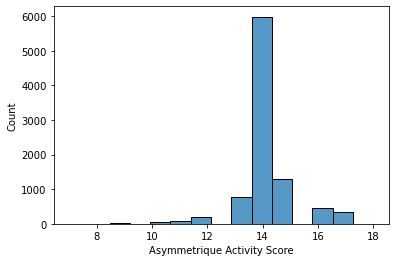

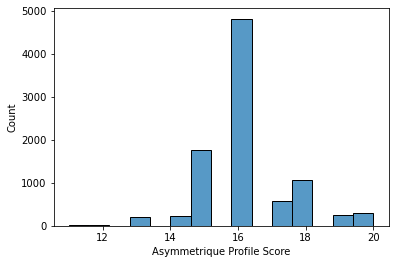

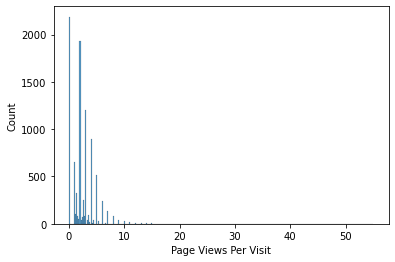

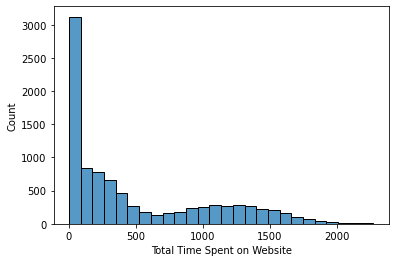

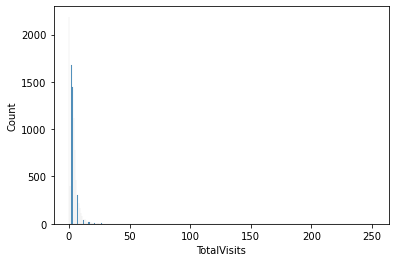

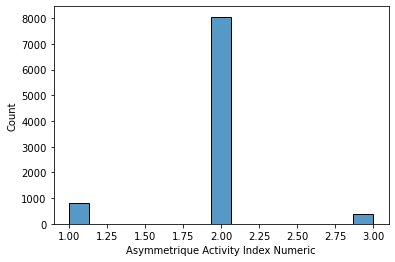

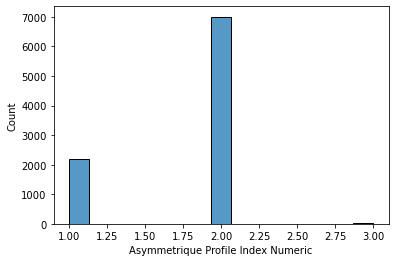

In [30]:
for i in num_cols:
    sns.histplot(x=df_clean[i])
    plt.show()

#### UNIVARIATE ANALYSIS (CATEGORICAL)

for i in cat_cols:
    sns.countplot(x=df_clean[i])
    plt.show()

#### HEATMAP to VISUALIZE any co-relation 

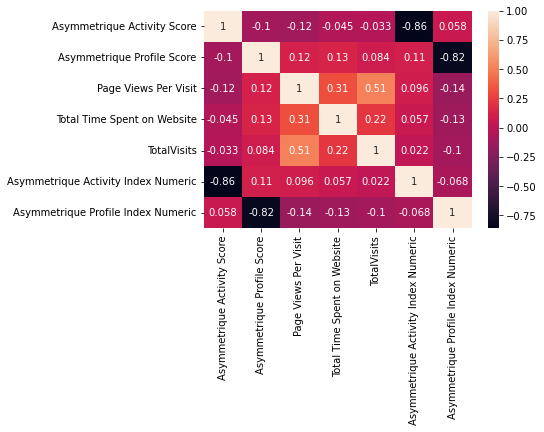

In [31]:
sns.heatmap(df_clean[num_cols].corr(), annot=True)
plt.show()

#### PRE-PROCESSING (one-hot encoding)

In [32]:
#data =  df_clean
# Encode categorical variables using one-hot encoding
df_clean_dummies = pd.get_dummies(df_clean, columns = cat_cols, drop_first=True)

In [33]:
df_clean_dummies.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,Asymmetrique Activity Index Numeric,Asymmetrique Profile Index Numeric,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0.0,0,0.0,15.0,15.0,2,2,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,5.0,674,2.5,15.0,15.0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1532,2.0,14.0,20.0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,305,1.0,13.0,17.0,2,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2.0,1428,1.0,15.0,18.0,2,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [34]:
df_clean_dummies.columns.to_list()

['TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score',
 'Asymmetrique Activity Index Numeric',
 'Asymmetrique Profile Index Numeric',
 'Lead Origin_Landing Page Submission',
 'Lead Origin_Lead Add Form',
 'Lead Origin_Lead Import',
 'Lead Origin_Quick Add Form',
 'Lead Source_Direct Traffic',
 'Lead Source_Facebook',
 'Lead Source_Google',
 'Lead Source_Live Chat',
 'Lead Source_NC_EDM',
 'Lead Source_Olark Chat',
 'Lead Source_Organic Search',
 'Lead Source_Pay per Click Ads',
 'Lead Source_Press_Release',
 'Lead Source_Reference',
 'Lead Source_Referral Sites',
 'Lead Source_Social Media',
 'Lead Source_WeLearn',
 'Lead Source_Welingak Website',
 'Lead Source_bing',
 'Lead Source_blog',
 'Lead Source_google',
 'Lead Source_testone',
 'Lead Source_welearnblog_Home',
 'Lead Source_youtubechannel',
 'Do Not Email_Yes',
 'Do Not Call_Yes',
 'Converted_1',
 'Last Activity_Converted to Lead',
 'Last Activity_E

In [35]:
df_clean_dummies.shape

(9240, 167)

#### TEST-TRAIN SPLIT 

In [36]:
X=df_clean_dummies.drop("Converted_1",axis=1)
Y=df_clean_dummies["Converted_1"]

In [37]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2,random_state=100)

In [38]:
print("Train X shape:", X_train.shape)
print("Test X shape:", X_test.shape)
print("Train Y shape:", Y_train.shape)
print("Test Y shape:", Y_test.shape)

Train X shape: (7392, 166)
Test X shape: (1848, 166)
Train Y shape: (7392,)
Test Y shape: (1848,)


#### SCALE THE DATA using MinMaxScalar

In [39]:
scalar = MinMaxScaler()

In [40]:
X_train_Scaled = scalar.fit_transform(X_train)
X_test_Scaled = scalar.transform(X_test)

In [41]:
X_test_Scaled = pd.DataFrame(X_test_Scaled,columns=X_test.columns)
X_train_Scaled = pd.DataFrame(X_train_Scaled,columns=X_train.columns)

In [42]:
X_train_Scaled.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,Asymmetrique Activity Index Numeric,Asymmetrique Profile Index Numeric,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0.000000,0.000000,0.000000,0.818182,0.444444,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.007968,0.060739,0.036364,0.636364,0.555556,0.5,0.5,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.007968,0.034771,0.036364,0.727273,0.555556,0.5,0.5,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.015936,0.694982,0.072727,0.636364,0.555556,0.5,0.5,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.727273,0.444444,0.5,0.5,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### FEATURE SELECTION using RFE with LOGISTIC REGRESSION

Use Recursive Feature Elimination (RFE) to select the most relevant features for a model, going with 20 features

In [43]:
estimator = LogisticRegression()
selector = RFE(estimator,n_features_to_select=20)
selector.fit(X_train_Scaled,Y_train)
selector.support_

array([False,  True,  True,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False,  True,  True,
       False, False,

In [44]:
cols_to_keep=X_train_Scaled.columns[selector.support_]

In [45]:
cols_to_keep

Index(['Total Time Spent on Website', 'Page Views Per Visit',
       'Asymmetrique Activity Score', 'Lead Origin_Lead Add Form',
       'Lead Source_Welingak Website', 'Last Activity_SMS Sent',
       'What is your current occupation_Working Professional', 'Tags_Busy',
       'Tags_Closed by Horizzon', 'Tags_Lateral student', 'Tags_Lost to EINS',
       'Tags_Ringing', 'Tags_Will revert after reading the email',
       'Tags_in touch with EINS', 'Tags_switched off', 'Lead Quality_Might be',
       'Lead Quality_Not Sure', 'Lead Quality_Worst',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')

In [46]:
#limit the X-train, X_test to selected features

X_train=X_train_Scaled[cols_to_keep]
X_test = X_test_Scaled[cols_to_keep]

In [47]:
print("Train X shape:", X_train.shape)
print("Test X shape:", X_test.shape)
print("Scaled Train X shape:", X_train_Scaled.shape)
print("Scaled Test X shape:", X_test_Scaled.shape)
print("Train Y shape:", Y_train.shape)
print("Test Y shape:", Y_test.shape)

Train X shape: (7392, 20)
Test X shape: (1848, 20)
Scaled Train X shape: (7392, 166)
Scaled Test X shape: (1848, 166)
Train Y shape: (7392,)
Test Y shape: (1848,)


#### Build and train the model

In [48]:
X_train_sm = sm.add_constant(X_train,has_constant="add")
X_test_sm = sm.add_constant(X_test,has_constant="add")

#### USE Generalized Linear Model (GLM) going with Binomial Distribution

In [49]:
model1 = sm.GLM(np.array(Y_train), X_train_sm, family=sm.families.Binomial())

#Binomial --> Binary Classification
result1 = model1.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7371
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1695.1
Date:                Sun, 16 Feb 2025   Deviance:                       3390.2
Time:                        22:16:40   Pearson chi2:                 1.89e+04
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -6.1991      0.453    -13.696      0.000      -7.086      -5.312
Total Time Spent on Website                              4.3934      0.205     21.456      0.000       3.992       4.795
Page Views Per Visit                                    -4.2462      1.286     -3.302      0.001      -6.767      -1.726
Asymmetrique Activity Score                              6.0167      0.529     11.383      0.000       4.981       7.053
Lead Origin_Lead Add Form                                2.3040      0.270      8.548      0.000       1.776       2.832
Lead Source_Welingak Website                             2.4872      0.782      3.179      0.001       0.954       4.021
Last Activity_SMS Sent                                   2.1836      0.100     21.843      0.000       1.988       2.379
What is your current occupation_Working Professional     2.4456      0.247      9.900      0.000       1.961       2.930
Tags_Busy                                                2.6330      0.329      7.993      0.000       1.987       3.279
Tags_Closed by Horizzon                                  9.8378      1.068      9.210      0.000       7.744      11.931
Tags_Lateral student                                    24.7218   1.52e+04      0.002      0.999   -2.97e+04    2.98e+04
Tags_Lost to EINS                                        9.6643      0.669     14.437      0.000       8.352      10.976
Tags_Ringing                                            -1.0420      0.324     -3.217      0.001      -1.677      -0.407
Tags_Will revert after reading the email                 4.1322      0.256     16.140      0.000       3.630       4.634
Tags_in touch with EINS                                  3.6435      1.032      3.531      0.000       1.621       5.666
Tags_switched off                                       -1.2061      0.582     -2.072      0.038      -2.347      -0.065
Lead Quality_Might be                                   -3.4235      0.204    -16.755      0.000      -3.824      -3.023
Lead Quality_Not Sure                                   -1.8466      0.276     -6.683      0.000      -2.388      -1.305
Lead Quality_Worst                                      -3.8543      0.696     -5.542      0.000      -5.218      -2.491
Last Notable Activity_Modified                          -1.8516      0.103    -17.947      0.000      -2.054      -1.649
Last Notable Activity_Olark Chat Conversation           -1.9912      0.352     -5.654      0.000      -2.681      -1.301
========================================================================================================================
"""

In [50]:
model2 = sm.GLM(np.array(Y_train), X_train_sm, family=sm.families.Binomial())
result2 = model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 7392
Model:                            GLM   Df Residuals:                     7371
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1695.1
Date:                Sun, 16 Feb 2025   Deviance:                       3390.2
Time:                        22:16:40   Pearson chi2:                 1.89e+04
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -6.1991      0.453    -13.696      0.000      -7.086      -5.312
Total Time Spent on Website                              4.3934      0.205     21.456      0.000       3.992       4.795
Page Views Per Visit                                    -4.2462      1.286     -3.302      0.001      -6.767      -1.726
Asymmetrique Activity Score                              6.0167      0.529     11.383      0.000       4.981       7.053
Lead Origin_Lead Add Form                                2.3040      0.270      8.548      0.000       1.776       2.832
Lead Source_Welingak Website                             2.4872      0.782      3.179      0.001       0.954       4.021
Last Activity_SMS Sent                                   2.1836      0.100     21.843      0.000       1.988       2.379
What is your current occupation_Working Professional     2.4456      0.247      9.900      0.000       1.961       2.930
Tags_Busy                                                2.6330      0.329      7.993      0.000       1.987       3.279
Tags_Closed by Horizzon                                  9.8378      1.068      9.210      0.000       7.744      11.931
Tags_Lateral student                                    24.7218   1.52e+04      0.002      0.999   -2.97e+04    2.98e+04
Tags_Lost to EINS                                        9.6643      0.669     14.437      0.000       8.352      10.976
Tags_Ringing                                            -1.0420      0.324     -3.217      0.001      -1.677      -0.407
Tags_Will revert after reading the email                 4.1322      0.256     16.140      0.000       3.630       4.634
Tags_in touch with EINS                                  3.6435      1.032      3.531      0.000       1.621       5.666
Tags_switched off                                       -1.2061      0.582     -2.072      0.038      -2.347      -0.065
Lead Quality_Might be                                   -3.4235      0.204    -16.755      0.000      -3.824      -3.023
Lead Quality_Not Sure                                   -1.8466      0.276     -6.683      0.000      -2.388      -1.305
Lead Quality_Worst                                      -3.8543      0.696     -5.542      0.000      -5.218      -2.491
Last Notable Activity_Modified                          -1.8516      0.103    -17.947      0.000      -2.054      -1.649
Last Notable Activity_Olark Chat Conversation           -1.9912      0.352     -5.654      0.000      -2.681      -1.301
========================================================================================================================
"""

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_sm.columns

vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i)
                  for i in range(len(X_train_sm.columns))]

vif_data

,Feature,VIF
0,const,71.593875
1,Total Time Spent on Website,1.235849
2,Page Views Per Visit,1.216842
3,Asymmetrique Activity Score,1.081318
4,Lead Origin_Lead Add Form,1.638542
5,Lead Source_Welingak Website,1.254974
6,Last Activity_SMS Sent,1.188234
7,What is your current occupation_Working Profes...,1.117504
8,Tags_Busy,1.247659
9,Tags_Closed by Horizzon,1.616837


In [52]:
output = pd.DataFrame()
output["predictions"] = result2.predict(X_test_sm)
output

,predictions
0,0.865213
1,0.998883
2,0.832854
3,0.011802
4,0.983141
...,...
1843,0.233704
1844,0.054151
1845,0.301474
1846,0.000443


### GET THE "LEAD SCORE" BASED ON PREDICTION PERCENTAGES

In [53]:
output["Lead_Score"] = output["predictions"] * 100
output.sort_values(by = 'Lead_Score', ascending=False)

,predictions,Lead_Score
605,0.999999,99.999913
546,0.999999,99.999859
915,0.999998,99.999803
1091,0.999998,99.999787
1770,0.999997,99.999709
...,...,...
1839,0.000060,0.006025
1067,0.000057,0.005729
104,0.000046,0.004578
89,0.000030,0.003004


#### Evaluate the model using various metrics

In [54]:
y_pred = selector.predict(X_test_Scaled)
y_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

#### Optimize the model

In [55]:
# Define the hyperparameters and grid search
param_grid = {'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, Y_train)

# Display the best parameters and score
print('Best HyperParameters:', grid_search.best_params_)
print('\n\n')
print('Best Score:', grid_search.best_score_)
print('\n\n')

# Evaluate the best model on the test set
model_best = grid_search.best_estimator_
y_pred = model_best.predict(X_test)

print('Accuracy:', accuracy_score(Y_test, y_pred))
print('\n\n')
print('Confusion Matrix:\n', confusion_matrix(Y_test, y_pred))
print('\n\n')
print('Classification Report:\n', classification_report(Y_test, y_pred))

Best HyperParameters: {'C': 1}



Best Score: 0.9115252689662492



Accuracy: 0.9074675324675324



Confusion Matrix:
 [[1040   76]
 [  95  637]]



Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      1116
           1       0.89      0.87      0.88       732

    accuracy                           0.91      1848
   macro avg       0.90      0.90      0.90      1848
weighted avg       0.91      0.91      0.91      1848



### Accuracy
Overall Accuracy is 90.75% which is the ratio of correctly predicted instances to the total instances. 
Hence, overall performance measure of the model.

### Precision
Precision (also called Positive Predictive Value) measures the accuracy of the positive predictions.
Seemingly 92% is high precision.

### Recall
Recall (also called Sensitivity or True Positive Rate) measures the model's ability to capture positive instances.
Seemingly 93% is high recall.